Business Problem: When it comes to demand of an item, usually follows the economic rule: as price drops, demand increases and vice versa. 

I recently did an analysis at work that looked at 5 different categories from the highest grossing GMV categories and the most searched item. And it was surprising to see user behavior as price dropped. For some categories, users were insensitive to price drops. They would buy an athletic apparel at whatever cost because of brand affinity.

Metric want to lift: GMV by seeing which categories have the highest potential of long-term revenue gain.

# Hypothesis: 

For items that are not necessary, demand could go up if price goes down. If an item is a day-to-day necessity then demand will be consistent and possibly even grow despite change in price.

# Analytic Approach:
1. Take a look at highest grossing categories  
2. Examine user behavior/demand as price changes for each (price vs (demand, promotions, discounts)
3. Perform linear regression on change in price results in what change in user behavior
4. Look at location as an indicator of who is most price elastic/inelastic

In [1]:
import numpy as np
import pandas as pd

import matplotlib.dates as dates
from datetime import datetime

import altair as alt

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots


from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv('../input/ecommerce-events-history-in-electronics-store/events.csv', engine='python')
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2020-09-24 11:57:06 UTC,view,1996170,2144415922528452715,electronics.telephone,NaN,31.90,1515915625519388267,LJuJVLEjPT
1,2020-09-24 11:57:26 UTC,view,139905,2144415926932472027,computers.components.cooler,zalman,17.16,1515915625519380411,tdicluNnRY
2,2020-09-24 11:57:27 UTC,view,215454,2144415927158964449,NaN,NaN,9.81,1515915625513238515,4TMArHtXQy
3,2020-09-24 11:57:33 UTC,view,635807,2144415923107266682,computers.peripherals.printer,pantum,113.81,1515915625519014356,aGFYrNgC08
4,2020-09-24 11:57:36 UTC,view,3658723,2144415921169498184,NaN,cameronsino,15.87,1515915625510743344,aa4mmk0kwQ


In [3]:
df.describe()

,product_id,category_id,price,user_id
count,8.851290e+05,8.851290e+05,885129.000000,8.851290e+05
mean,1.906621e+06,2.144423e+18,146.328713,1.515916e+18
std,1.458708e+06,6.165105e+14,296.807683,3.554165e+07
min,1.020000e+02,2.144416e+18,0.220000,1.515916e+18
25%,6.988030e+05,2.144416e+18,26.460000,1.515916e+18
50%,1.452883e+06,2.144416e+18,65.710000,1.515916e+18
75%,3.721194e+06,2.144416e+18,190.490000,1.515916e+18
max,4.183880e+06,2.227847e+18,64771.060000,1.515916e+18


In [4]:
df.shape

(885129, 9)

In [5]:
df.event_type.value_counts()

view        793748
cart         54035
purchase     37346
Name: event_type, dtype: int64

In [6]:
df2 = df = pd.read_csv('../input/ecommerce-purchase-history-from-electronics-store/kz.csv', engine='python')
df2.head()

,event_time,order_id,product_id,category_id,category_code,brand,price,user_id
0,2020-04-24 11:50:39 UTC,2294359932054536986,1515966223509089906,2.268105e+18,electronics.tablet,samsung,162.01,1.515916e+18
1,2020-04-24 11:50:39 UTC,2294359932054536986,1515966223509089906,2.268105e+18,electronics.tablet,samsung,162.01,1.515916e+18
2,2020-04-24 14:37:43 UTC,2294444024058086220,2273948319057183658,2.268105e+18,electronics.audio.headphone,huawei,77.52,1.515916e+18
3,2020-04-24 14:37:43 UTC,2294444024058086220,2273948319057183658,2.268105e+18,electronics.audio.headphone,huawei,77.52,1.515916e+18
4,2020-04-24 19:16:21 UTC,2294584263154074236,2273948316817424439,2.268105e+18,NaN,karcher,217.57,1.515916e+18


In [7]:
df2['event_time'] = df2['event_time'].apply(lambda s: str(s)[0:10])
df2.head()

,event_time,order_id,product_id,category_id,category_code,brand,price,user_id
0,2020-04-24,2294359932054536986,1515966223509089906,2.268105e+18,electronics.tablet,samsung,162.01,1.515916e+18
1,2020-04-24,2294359932054536986,1515966223509089906,2.268105e+18,electronics.tablet,samsung,162.01,1.515916e+18
2,2020-04-24,2294444024058086220,2273948319057183658,2.268105e+18,electronics.audio.headphone,huawei,77.52,1.515916e+18
3,2020-04-24,2294444024058086220,2273948319057183658,2.268105e+18,electronics.audio.headphone,huawei,77.52,1.515916e+18
4,2020-04-24,2294584263154074236,2273948316817424439,2.268105e+18,NaN,karcher,217.57,1.515916e+18


In [8]:
df2.category_code.value_counts()

electronics.smartphone              357682
appliances.kitchen.refrigerators     77386
16.18                                72969
electronics.video.tv                 71711
computers.notebook                   71436
                                     ...  
31.25                                    1
106.43                                   1
92.34                                    1
31.94                                    1
347.20                                   1
Name: category_code, Length: 510, dtype: int64

In [9]:
df2.category_id.value_counts()

2.268105e+18    338328
2.268105e+18     66146
2.374499e+18     59344
2.268105e+18     58569
2.268105e+18     51864
                 ...  
2.268105e+18         1
2.268105e+18         1
2.268106e+18         1
2.268105e+18         1
2.268105e+18         1
Name: category_id, Length: 901, dtype: int64

In [10]:
df2.shape

(2633521, 8)

In [11]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2633521 entries, 0 to 2633520
Data columns (total 8 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   order_id       int64  
 2   product_id     int64  
 3   category_id    float64
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        float64
dtypes: float64(3), int64(2), object(3)
memory usage: 160.7+ MB


In [12]:
df2_agg = df2.groupby('category_code') \
       .agg({'category_code':'size', 'price':'mean'}) \
       .rename(columns={'category_code':'total_tx','price':'avg_price_per_item'}) \
       .reset_index()

df2_agg

,category_code,total_tx,avg_price_per_item
0,0.00,3721,NaN
1,0.02,17,NaN
2,0.03,18,NaN
3,0.05,427,NaN
4,0.12,2,NaN
...,...,...,...
505,sport.trainer,219,292.364840
506,stationery.battery,24940,3.202756
507,stationery.cartrige,10718,12.397065
508,stationery.paper,3700,4.421457


In [13]:
df2_agg.sort_values(['total_tx'], ascending=[False])[:20]

,category_code,total_tx,avg_price_per_item
475,electronics.smartphone,357682,286.965165
417,appliances.kitchen.refrigerators,77386,407.153718
100,16.18,72969,NaN
479,electronics.video.tv,71711,408.601552
445,computers.notebook,71436,438.919187
400,appliances.environment.vacuum,66471,138.978852
468,electronics.audio.headphone,66159,65.151228
412,appliances.kitchen.kettle,62719,32.544524
420,appliances.kitchen.washer,56255,328.371720
486,furniture.kitchen.table,55725,38.172499


In [14]:
non_null_price = df2_agg[df2_agg['avg_price_per_item'].notnull()]
purchase_top10 = non_null_price.sort_values(['total_tx'], ascending=[False])[:10]
purchase_top10

,category_code,total_tx,avg_price_per_item
475,electronics.smartphone,357682,286.965165
417,appliances.kitchen.refrigerators,77386,407.153718
479,electronics.video.tv,71711,408.601552
445,computers.notebook,71436,438.919187
400,appliances.environment.vacuum,66471,138.978852
468,electronics.audio.headphone,66159,65.151228
412,appliances.kitchen.kettle,62719,32.544524
420,appliances.kitchen.washer,56255,328.371720
486,furniture.kitchen.table,55725,38.172499
450,computers.peripherals.mouse,45329,17.621449


In [15]:
df2_agg_time = df2.groupby(['event_time', 'category_code']) \
       .agg({'category_code':'size', 'price':'mean'}) \
       .rename(columns={'category_code':'total_tx','price':'avg_price_per_item'}) \
       .reset_index()

df2_agg_time_no_nulls = df2_agg_time[df2_agg_time['avg_price_per_item'].notnull()]

df2_agg_time_no_nulls.sort_values(['total_tx'], ascending=[False])[:10]

,event_time,category_code,total_tx,avg_price_per_item
36522,2020-09-01,electronics.smartphone,3589,258.316364
11436,2020-03-08,electronics.smartphone,3269,243.841297
34072,2020-08-17,electronics.smartphone,3247,310.082338
11244,2020-03-07,electronics.smartphone,3184,244.908238
34266,2020-08-18,electronics.smartphone,3089,307.058032
35207,2020-08-24,electronics.smartphone,2977,289.658791
173,1970-01-01,electronics.smartphone,2834,249.403606
35949,2020-08-28,electronics.smartphone,2759,289.896169
25038,2020-06-14,electronics.smartphone,2742,235.870930
24846,2020-06-13,electronics.smartphone,2725,225.252323


In [16]:
def demand_time_graph():
    
    categories = ['electronics.smartphone'
              , 'appliances.kitchen.refrigerators'
              , 'electronics.video.tv'
              , 'computers.notebook'
              , 'appliances.environment.vacuum'
              , 'electronics.audio.headphone']
    
    for c in categories:
        category_df = df2_agg_time_no_nulls.loc[df2_agg_time_no_nulls['category_code'] == c]
        category_df = category_df.loc[category_df['event_time'].str.startswith('202')]
        category_df['event_time'].min(),category_df['event_time'].max()
        fig = go.Figure(data=go.Scatter(x=category_df['event_time'], 
                                    y=category_df['total_tx'],
                                    marker_color='red', text="sales"))

        fig.update_layout({
                       "xaxis": {"title":"Date"},
                       "yaxis": {"title":"Total Sold"},
                       "showlegend": False})
        print('Total Sales by date for ', c)
        fig.show()
demand_time_graph()

Total Sales by date for  electronics.smartphone


Total Sales by date for  appliances.kitchen.refrigerators


Total Sales by date for  electronics.video.tv


Total Sales by date for  computers.notebook


Total Sales by date for  appliances.environment.vacuum


Total Sales by date for  electronics.audio.headphone


There is some seasonality every 3 months with peaks every 3 months starting from March.

# Health Tracker Product Sales in India

## EDA

In [17]:
health = pd.read_csv('../input/fitness-trackers-products-ecommerce/Fitness_trackers_updated.csv')
health.head()

,Brand Name,Device Type,Model Name,Color,Selling Price,Original Price,Display,Rating (Out of 5),Strap Material,Average Battery Life (in days),Reviews
0,Xiaomi,FitnessBand,Smart Band 5,Black,"2,499","2,999",AMOLED Display,4.1,Thermoplastic polyurethane,14,NaN
1,Xiaomi,FitnessBand,Smart Band 4,Black,"2,099","2,499",AMOLED Display,4.2,Thermoplastic polyurethane,14,NaN
2,Xiaomi,FitnessBand,HMSH01GE,Black,"1,722","2,099",LCD Display,3.5,Leather,14,NaN
3,Xiaomi,FitnessBand,Smart Band 5,Black,"2,469","2,999",AMOLED Display,4.1,Thermoplastic polyurethane,14,NaN
4,Xiaomi,FitnessBand,Band 3,Black,"1,799","2,199",OLED Display,4.3,Plastic,7,NaN


In [18]:
#How rich is our data. Just 610 rows.
health.dtypes

Brand Name                         object
Device Type                        object
Model Name                         object
Color                              object
Selling Price                      object
Original Price                     object
Display                            object
Rating (Out of 5)                 float64
Strap Material                     object
Average Battery Life (in days)      int64
Reviews                            object
dtype: object

In [19]:
health["Selling Price"] = health["Selling Price"].str.replace(',','').astype(int)
health["Original Price"] = health["Original Price"].str.replace(',','').astype(int)
health.dtypes

Brand Name                         object
Device Type                        object
Model Name                         object
Color                              object
Selling Price                       int64
Original Price                      int64
Display                            object
Rating (Out of 5)                 float64
Strap Material                     object
Average Battery Life (in days)      int64
Reviews                            object
dtype: object

In [20]:
#Data Integrity
health.isnull().sum()

Brand Name                          0
Device Type                         0
Model Name                          0
Color                               0
Selling Price                       0
Original Price                      0
Display                             0
Rating (Out of 5)                  56
Strap Material                      0
Average Battery Life (in days)      0
Reviews                           496
dtype: int64

In [21]:
health.describe()

,Selling Price,Original Price,Rating (Out of 5),Average Battery Life (in days)
count,610.000000,610.000000,554.000000,610.000000
mean,20706.859016,23977.503279,4.195668,8.926230
std,19803.690357,20242.634014,0.422576,7.632107
min,799.000000,1599.000000,2.000000,1.000000
25%,6995.000000,10249.000000,4.000000,2.000000
50%,14999.000000,18995.000000,4.200000,7.000000
75%,27467.500000,31416.750000,4.500000,14.000000
max,122090.000000,122090.000000,5.000000,45.000000


# Business Questions We Want to Ask
1. What are the most popular brands/device types?
2. What is the relationship between orignal and sale price?
3. What is the relationship between change in price and demand?

In [22]:
brand = health['Brand Name'].value_counts()
brand

FOSSIL             133
GARMIN             101
APPLE               86
FitBit              51
SAMSUNG             48
huami               36
Huawei              26
Noise               20
Honor               20
Fire-Boltt          14
realme              12
Zebronics           12
Xiaomi              10
Crossbeats           8
Fastrack             6
boAt                 5
Ptron                5
GOQii                4
OnePlus              3
Oppo                 2
Noise                2
LCARE                2
dizo by realme       2
LAVA                 1
Infinix              1
Name: Brand Name, dtype: int64

In [23]:
fig = px.pie(brand, values=brand.values, names=brand.index)
fig.show()

In [24]:
type = health['Device Type'].value_counts()
type

Smartwatch     533
FitnessBand     77
Name: Device Type, dtype: int64

In [25]:
fig = px.pie(type, values=type.values, names=type.index)
fig.show()

In [26]:
health.head()

,Brand Name,Device Type,Model Name,Color,Selling Price,Original Price,Display,Rating (Out of 5),Strap Material,Average Battery Life (in days),Reviews
0,Xiaomi,FitnessBand,Smart Band 5,Black,2499,2999,AMOLED Display,4.1,Thermoplastic polyurethane,14,NaN
1,Xiaomi,FitnessBand,Smart Band 4,Black,2099,2499,AMOLED Display,4.2,Thermoplastic polyurethane,14,NaN
2,Xiaomi,FitnessBand,HMSH01GE,Black,1722,2099,LCD Display,3.5,Leather,14,NaN
3,Xiaomi,FitnessBand,Smart Band 5,Black,2469,2999,AMOLED Display,4.1,Thermoplastic polyurethane,14,NaN
4,Xiaomi,FitnessBand,Band 3,Black,1799,2199,OLED Display,4.3,Plastic,7,NaN


In [27]:
agg = health.groupby(['Brand Name']) \
       .agg({'Brand Name':'size', 'Selling Price':'mean', 'Original Price':'mean'}) \
       .rename(columns={'Brand Name':'total_tx','Selling Price':'avg_sell_price', 'Original Price':'avg_original_price'}) \
       .reset_index()

agg.sort_values(['total_tx'], ascending=[False]) 

,Brand Name,total_tx,avg_sell_price,avg_original_price
2,FOSSIL,133,13824.954887,16784.766917
6,GARMIN,101,35038.227723,40120.930693
0,APPLE,86,49413.837209,51127.441860
5,FitBit,51,14018.843137,17409.549020
18,SAMSUNG,48,22901.375000,26980.770833
23,huami,36,7547.638889,11120.722222
9,Huawei,26,15874.615385,20751.538462
14,Noise,20,3414.700000,5999.000000
8,Honor,20,5510.000000,7824.050000
4,Fire-Boltt,14,3741.500000,8427.571429


In [28]:
alt.Chart(health, title="Original Price vs Selling Price").mark_point(filled=True,size=40).encode(
    x='Original Price',
    y='Selling Price',
    color='Brand Name',
    tooltip=['Brand Name', 'Selling Price', 'Original Price']
).interactive()

alt.Chart(...)

Looks like there are more discounts/deviations from original price at lower band of prices. Whereas for Apple most sells are at sticker price. Apple and GARMIN seem to have the most products at different price tiers. GARMIN is Apple's biggest competitor for variable products and it has more discounts versus Apple. At the lower end of pricing, FOSSIL seems to have the most discounts at varying low priced original sale prices. And FitBit has sales that have the highest discounts.

With this observation, would be safe to assume that with change of price Apple demand would be inelastic whereas with FitBit would be more elastic. Let's take a look with another graph.

Given the market behavior behind APPLE vs. GARMIN, FOSSIL and FitBit, let's take a look at some of the different features of each brand including battery life and ratings.

In [29]:
agg = health.groupby(['Brand Name', 'Model Name']) \
       .agg({'Model Name':'size', 'Selling Price':'mean', 'Original Price':'mean'}) \
       .rename(columns={'Model Name':'model_total_tx','Selling Price':'avg_model_sell_price', 'Original Price':'avg_model_original_price'}) \
       .reset_index()

agg.sort_values(['model_total_tx'], ascending=[False]) 

,Brand Name,Model Name,model_total_tx,avg_model_sell_price,avg_model_original_price
181,FitBit,Charge 2,8,11436.375000,14999.0
132,FOSSIL,Gen 5 Julianna HR,6,17161.666667,21495.0
135,FOSSIL,Jacqueline Hybrid,5,10455.200000,12895.0
402,huami,Amazfit Bip,5,5569.200000,6675.4
412,huami,Amazfit GTS,4,5574.000000,12999.0
...,...,...,...,...,...
155,FOSSIL,Rose Gold Smart,1,21995.000000,21995.0
154,FOSSIL,Rose Gold HR,1,21995.000000,21995.0
151,FOSSIL,Q Neely,1,6995.000000,12995.0
150,FOSSIL,Q Machine,1,10796.000000,13495.0


In [30]:
alt.Chart(agg, title="Average Original Price vs Total Demand").mark_point(filled=True,size=40).encode(
    x='avg_model_original_price',
    y='model_total_tx',
    color='Brand Name',
    tooltip=['Brand Name', 'model_total_tx', 'avg_model_original_price']
).interactive()

alt.Chart(...)

We can see here that across brands' models, it does look like as price increases, demand decreases as is clear with Apple models (blue) set at different price points. Though with GARMIN, demand continues to be high across different price points (purple). The same is for Samsung (brown) even though range of models may not be as huge as Apple. So Apple seems to be price elastic whereas GARMIN and Samsung seem not be so much. We will verify this later! For now, let's examine what differentiates these products/their moats.

<AxesSubplot:xlabel='count', ylabel='Brand Name'>

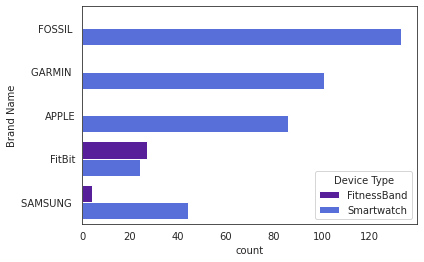

In [31]:
#What's the most bought color for fitness tracker enthusiasts:
sns.set_style('white')
sns.countplot(y="Brand Name", hue="Device Type", data=health, palette=["#560bad","#4361EE"],
              order=health["Brand Name"].value_counts().iloc[:5].index)

In [32]:
prod_offerings = health.groupby('Brand Name')['Model Name'].nunique().sort_values(ascending=False).reset_index(name='count')
fig = px.pie(prod_offerings, values=prod_offerings['count'], names=prod_offerings['Brand Name'])
fig.show()

Suprisingly, FOSSIL has the most product offerings with GARMIN and Apple not far behind. Though FOSSIL has more product offerings, they are all at similar tiered price.

## Most popular fitness tracker band color

In [33]:
fig = px.bar(health, health.Color.value_counts().index, y=health.Color.value_counts().values)
fig.show()

## Is this true for top 20 grossing trackers?

In [34]:
top20_gross = agg.sort_values(['model_total_tx'], ascending=[False])[:20]
top20_gross['Brand Name'].value_counts()

FOSSIL      8
FitBit      4
huami       4
GARMIN      2
SAMSUNG     1
Honor       1
Name: Brand Name, dtype: int64

In [35]:
health.loc[health['Brand Name'].isin(top20_gross['Brand Name'].value_counts().index)].Color.value_counts()

Black             122
Blue               26
Silver             25
Gold               20
Grey               17
                 ... 
Black, Red          1
Olive Green         1
Navy Blue           1
Dynamic Orange      1
Frost Blue          1
Name: Color, Length: 104, dtype: int64

We can see here that Black is the most popular color with a huge tail. We can also see that there is some data integrity issues (color Black shows up 2x probably due to formatting from web scrape).

In [36]:
list(health)

['Brand Name',
 'Device Type',
 'Model Name',
 'Color',
 'Selling Price',
 'Original Price',
 'Display',
 'Rating (Out of 5)',
 'Strap Material',
 'Average Battery Life (in days)',
 'Reviews']

## Let's see the most popular Display, Strap Material and Average Battery Life (in days).

In [37]:
tracker_qualities = ['Color', 'Display', 'Strap Material', 'Average Battery Life (in days)']

for x in tracker_qualities:

    fig = px.bar(health, health[x].value_counts().index, y=health[x].value_counts().values)
    print('Most popular fitness trackers\'', x)
    fig.show()

Most popular fitness trackers' Color


Most popular fitness trackers' Display


Most popular fitness trackers' Strap Material


Most popular fitness trackers' Average Battery Life (in days)


## How about the top 20 most grossing tracker qualities (what types of fitness trackers are consumers spending the most on)?

In [38]:
for x in tracker_qualities:

    df = health.loc[health['Brand Name'].isin(top20_gross['Brand Name'].value_counts().index)]
    print(x, 'value counts')
    print('')
    print(df[x].value_counts())
    print('')
    print('')
    fig = px.bar(df, df[x].value_counts().index, y=df[x].value_counts().values)
    print('Highest grossing fitness trackers\'', x)
    fig.show()

Color value counts

Black             122
Blue               26
Silver             25
Gold               20
Grey               17
                 ... 
Black, Red          1
Olive Green         1
Navy Blue           1
Dynamic Orange      1
Frost Blue          1
Name: Color, Length: 104, dtype: int64


Highest grossing fitness trackers' Color


Display value counts

AMOLED Display    302
OLED Display       31
LED Display        28
PMOLED Display     15
LCD Display        13
Name: Display, dtype: int64


Highest grossing fitness trackers' Display


Strap Material value counts

Silicone                      182
Stainless Steel                72
Leather                        55
Elastomer                      37
Plastic                        13
Thermoplastic polyurethane      9
Rubber                          9
Nylon                           9
Fabric                          1
leather                         1
Leather                         1
Name: Strap Material, dtype: int64


Highest grossing fitness trackers' Strap Material


Average Battery Life (in days) value counts

14    129
7      92
2      52
1      31
12     27
30     12
5      10
45      8
25      7
10      6
28      5
15      4
3       2
6       2
9       1
20      1
Name: Average Battery Life (in days), dtype: int64


Highest grossing fitness trackers' Average Battery Life (in days)


So looks like highest grossing fitness tracker qualities are: black, AMOLED display, Silicone with average batt lifespan of 14 days.

In [39]:
list(health)

['Brand Name',
 'Device Type',
 'Model Name',
 'Color',
 'Selling Price',
 'Original Price',
 'Display',
 'Rating (Out of 5)',
 'Strap Material',
 'Average Battery Life (in days)',
 'Reviews']

## Reviews

Let's see which Brands have the most buzz (reviews). This helps business see which products have the strongest appeal or lowest appeal since those who leave reviews are usually those who think they got a highly valued product or were jipped. For the strongest appeal, good to have those products with most R&D invested since have the best reputation and drop those products from shop that have lowest rating #'s.

In [40]:
# Total ratings by Brand
round(health.groupby('Brand Name')['Reviews'].size().sort_values(ascending=False).iloc[:10],1)

Brand Name
FOSSIL        133
GARMIN        101
APPLE          86
FitBit         51
SAMSUNG        48
huami          36
Huawei         26
Noise          20
Honor          20
Fire-Boltt     14
Name: Reviews, dtype: int64

## Average Ratings

Lastly, with ratings, let's see which ones have the highest quality regardless of number of ratings. These give insight into brand affinity and $$ for value.

In [41]:
#average ratings by Brand
round(health.groupby('Brand Name')['Rating (Out of 5)'].mean().sort_values(ascending=False).iloc[:10],1)

Brand Name
APPLE              4.5
OnePlus            4.3
dizo by realme     4.2
FOSSIL             4.2
SAMSUNG            4.2
Honor              4.2
FitBit             4.2
Xiaomi             4.2
Huawei             4.2
huami              4.2
Name: Rating (Out of 5), dtype: float64

Apple has the highest ratings. This explains why Apple owners say once you get into their ecosystem, it is hard to get out.

Lastly, let's take a look at our original question: how does change in price correspond to change of demand. Another question want to answer now is that with change of price, does that change the quality of a product, which we will use average rating as a proxy for that.